<H1> Filtering the effect of descrete labels by scPrisma</h1>

In this tutorial, we will demonstrate how to filter out the influence of discrete features stored in the 'obs' field of an anndata (<a href="https://scanpy.readthedocs.io/en/stable/">scanpy</a>) object. We will utilize certain functions to achieve this without requiring installation of scPrisma. As a practical example, we will apply batch correction to four datasets of pancreatic cells (obtained from the <a href="https://academic.oup.com/bioinformatics/article/36/3/964/5545955">BBKNN</a> paper).
It is recommended to follow the pre-processing and parameter selection procedures outlined in the scPrisma manuscript in order to optimize the results of the analysis.



In [1]:
import scanpy as sc
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import normalize

def filter_discrete_label_anndata(adata, label, regu=0, epsilon=0.1, iterNum=100, regu_norm='L1'):
    """
    Filters `adata` based on a discrete label by running gradient descent with L1 regularization.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object to filter.
    label : str
        Name of the column in `adata.obs` to use as the discrete label.
    regu : float
        Regularization coefficient.
    epsilon : float, optional
        Step size (learning rate).
    iterNum : int, optional
        Number of iterations to run gradient descent.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    
    Returns
    -------
    filtered_X : np.ndarray
        Filtered version of `adata.X`
    """
    bdata = adata.copy()
    one_hot = MultiLabelBinarizer()
    V =  one_hot.fit_transform(adata.obs[label])
    A = np.array((adata.X).copy())
    A = normalize(A, axis=1, norm='l2')
    F = gradient_descent_full(A, np.ones(A.shape), V=V, regu=0, epsilon=0.1, iterNum=100)
    bdata.X = bdata.X * F
    return bdata


def gradient_descent_full(A, F, V, regu, epsilon=0.1, iterNum=100, regu_norm='L1'):
    """
    Runs gradient descent to find the optimal filtering matrix `F` for the given gene expression matrix `A`,
    discrete labels `V`, and regularization coefficient `regu`.
    
    Parameters
    ----------
    A : np.ndarray
        Gene expression matrix.
    F : np.ndarray
        Initial filtering matrix.
    V : np.ndarray
        One-hot encoded discrete label matrix.
    regu : float
        Regularization coefficient.
    epsilon : float, optional
        Step size (learning rate).
    iterNum : int, optional
        Number of iterations to run gradient descent.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    
    Returns
    -------
    F : np.ndarray
        Optimal filtering matrix.
    """
    j = 0
    epsilon_t = epsilon
    while j < iterNum:
        if j % 100 == 1:
            print("Iteration number: " + str(j))
        epsilon_t *= 0.995
        tmp_value, grad = fAndG_full(A=A, B=F, V=V, regu=regu, regu_norm=regu_norm)
        F = F - epsilon_t * grad
        F = np.clip(F, 0, 1)
        j += 1
    return F

def fAndG_full(A, B, V, regu, regu_norm='L1'):
    """
    Calculates the projection of `B` over the theoretic spectrum `V` and the gradient of `B` according to `A`.
    
    Parameters
    ----------
    A : np.ndarray
        Gene expression matrix.
    B : np.ndarray
        Filtering matrix.
    V : np.ndarray
        One-hot encoded discrete label matrix.
    regu : float
        Regularization coefficient.
    regu_norm : str, optional
        Regularization norm to use, either 'L1' or 'L2'.
    Returns
    -------
    B : np.ndarray
        Filtering matrix.

    """
    if regu_norm == 'L1':
        T_0 = (A * B)
        t_1 = np.linalg.norm(B, 1)
        functionValue = (np.trace((((V.T).dot(T_0)).dot(T_0.T)).dot(V)) - (regu * t_1))
        gradient = ((2 * (((V).dot(V.T)).dot(T_0) * A)) - ((regu) * np.sign(B)))
    else:
        T_0 = (A * B)
        t_1 = np.linalg.norm(A * B, 'fro')
        functionValue = (np.trace((((V.T).dot(T_0)).dot(T_0.T)).dot(V)) - (regu * t_1))
        gradient = ((2 * (((V).dot(V.T)).dot(T_0) * A)) - ((regu / t_1) * B))
    return functionValue, gradient


Read the data (Polański, Krzysztof, et al. Bioinformatics (2020))

In [2]:
adata_all = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
sc.pp.subsample(adata_all, n_obs=5000)


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata_filtered = filter_discrete_label_anndata(adata_all,'batch')


Iteration number: 1


Visualization of the results

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


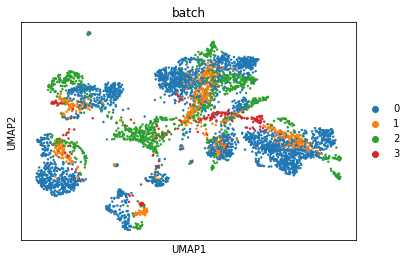

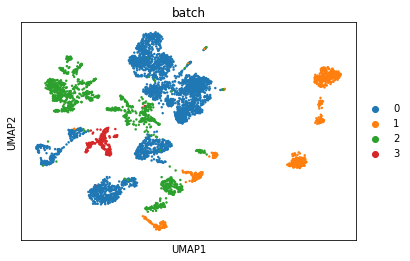

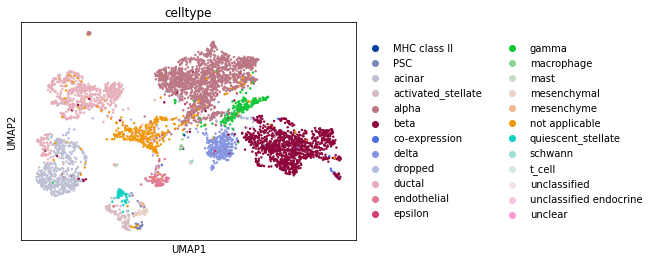

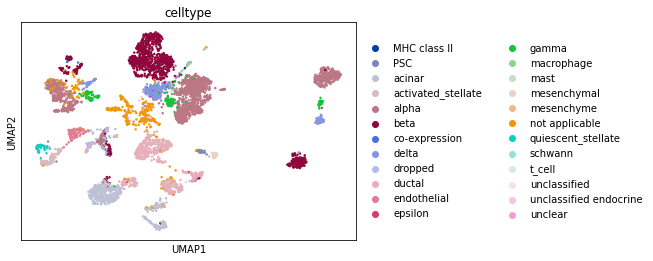

In [4]:
sc.pp.pca(adata_filtered)
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_filtered)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_filtered)
sc.tl.umap(adata_all)
sc.pl.umap(adata_filtered, color='batch')
sc.pl.umap(adata_all, color='batch')
sc.pl.umap(adata_filtered, color='celltype')
sc.pl.umap(adata_all, color='celltype')

To verify the quantitative results of a batch correction, the silhouette score can be used to measure the separation between the batches and cell-types. After the batch correction, the silhouette score between the batches should be lower, while the silhouette score between the cell-types should be higher.

In [6]:
from sklearn.metrics import silhouette_score
silhouette_score(adata_all.obsm['X_pca'], adata_all.obs['batch'])

0.21017452

In [7]:
silhouette_score(adata_filtered.obsm['X_pca'], adata_filtered.obs['batch'])

-0.088686354

In [8]:
silhouette_score(adata_all.obsm['X_pca'], adata_all.obs['celltype'])

-0.013698251

In [9]:
silhouette_score(adata_filtered.obsm['X_pca'], adata_filtered.obs['celltype'])

0.090419084